In [0]:
import numpy as np
import pandas as pd
import time
from itertools import combinations
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils import check_array, check_X_y

###**Inputs/Output for Hoeffding Tree**

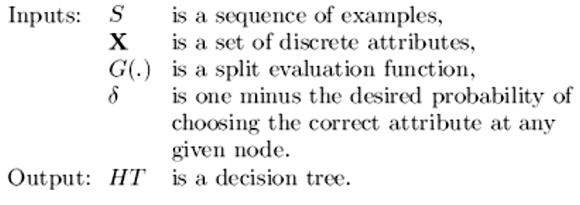

In [0]:
class VfdtNode:
  def __init__(self, possible_split_features):
    self.parent = None
    self.left_child = None
    self.right_child = None
    self.split_feature = None
    self.split_value = None  # can be continuous or discrete
    self.new_examples_seen = 0 #assigning new example counter as 0
    self.total_examples_seen = 0 #assigning total example counter as 0
    self.class_frequency = {} #assigning class frequency array as empty
    self.nijk = {f: {} for f in possible_split_features} #statistics of feature i, value j, class k
    self.possible_split_features = possible_split_features #features list

  def add_children(self, split_feature, split_value, left, right):
    #assigning values to the variables from the passed arguments
    self.split_feature = split_feature 
    self.split_value = split_value
    self.left_child = left
    self.right_child = right
    left.parent = self
    right.parent = self

    self.nijk.clear()  # reset stats
    if isinstance(split_value, list): #if the split value is of type discrete
      left_value = split_value[0] #left value
      right_value = split_value[1] #right value
      # discrete split value list's length = 1, stop splitting
      if len(left_value) <= 1:
        new_features = [None if f == split_feature else f #adding new features on corresponding left node
                        for f in left.possible_split_features]
        left.possible_split_features = new_features
      if len(right_value) <= 1:
        new_features = [None if f == split_feature else f #adding new features on corresponding right node
                        for f in right.possible_split_features]
        right.possible_split_features = new_features

  def is_leaf(self):
    return self.left_child is None and self.right_child is None #checking if the particular example belongs to a leaf

  def sort_example(self, x): #used for sorting the examples down the tree and to distribute data examples to corresponding leaves
    if self.is_leaf(): #determining if the example is a leaf
      return self
    else: #if it is not a leaf
      index = self.possible_split_features.index(self.split_feature) #split the features and assign the index of that feature to a variable
      value = x[index] #getting the value at that index
      split_value = self.split_value #assigning the type of feature: discrete or continuous

      if isinstance(split_value, list):  # if the value is discrete 
        if value in split_value[0]: #assigning to left child first
          return self.left_child.sort_example(x)
        else: #after assigning to left child, assign the example as a right child
          return self.right_child.sort_example(x)
      else:  # if the value is continuous 
        if value <= split_value: #all values lesser than the split value are assigned on the left side
          return self.left_child.sort_example(x)
        else: #greater values on the right side
          return self.right_child.sort_example(x)

  # the most frequent class
  def most_frequent(self):
    try:
      #getting the class with the maximum frequency
      prediction = max(self.class_frequency,
                        key=self.class_frequency.get)
    except ValueError:
      #if no such class is present then take the parent class into consideration
      class_frequency = self.parent.class_frequency
      prediction = max(class_frequency, key=class_frequency.get)
    return prediction

  # update leaf stats in order to calculate gini
  def update_stats(self, x, y):
    feats = self.possible_split_features #assigning all the features for that example into a var
    nijk = self.nijk #feature i, value j and class k
    iterator = [f for f in feats if f is not None]
    for i in iterator: #iterating over all features
      value = x[feats.index(i)] #assigning value using index
      if value not in nijk[i]: #if the obtained value is not in nijk
        nijk[i][value] = {y: 1}
      else:#if it is present then increment it else assign 1
        try:
          nijk[i][value][y] += 1
        except KeyError:
          nijk[i][value][y] = 1
    #increment the total examples and new examples 
    self.total_examples_seen += 1
    self.new_examples_seen += 1
    class_frequency = self.class_frequency
    try:#increment class frequency is class found
      class_frequency[y] += 1
    except KeyError: #assign class freq as 1 if class is not found
      class_frequency[y] = 1

  def check_not_splitting(self):
    # compute gini index for not splitting
    X0 = 1
    class_frequency = self.class_frequency #assigning class frequency
    n = sum(class_frequency.values()) #summing up all class frequencies
    for j, k in class_frequency.items(): #finding the ratio of a particular class' freq with the total
      X0 -= (k/n)**2
    return X0

  # use Hoeffding tree model to test node split, return the split feature
  def attempt_split(self, delta, nmin, tau):
      if self.new_examples_seen < nmin: #checking that the new example is less than nmin
          return None
      class_frequency = self.class_frequency #assigning class frequency
      if len(class_frequency) == 1: 
          return None

      self.new_examples_seen = 0 
      nijk = self.nijk #statistics of feature i, value j, class k
      min = 1 #assigning first miminum and second minimum as 1
      second_min = 1
      Xa = ''
      split_value = None
      for feature in self.possible_split_features:
          if feature is not None:
              njk = nijk[feature] #extracting feature(i)  
              gini, value = self.gini(njk, class_frequency) #calculating gini index using frequency
              if gini < min: #attribute with highest gini index
                  min = gini
                  Xa = feature
                  split_value = value
              elif min < gini < second_min:#attribute with second highest gini index
                  second_min = gini

      epsilon = self.hoeffding_bound(delta) #computing hoeffding bound
      g_X0 = self.check_not_splitting()
      if min < g_X0:
          if second_min - min > epsilon: #checking the difference between best and second best
              return [Xa, split_value]
          elif tau != 0 and second_min - min < epsilon < tau: #Tau is used to choose in between two attributes that has very close information gain 
              return [Xa, split_value]
          else:
              return None
      return None

  def hoeffding_bound(self, delta): #calculating hoeffding bound
      n = self.total_examples_seen
      R = np.log(len(self.class_frequency))
      return np.sqrt(R * R * np.log(1/delta) / (2 * n))

  def gini(self, njk, class_frequency): #function for computing gini index
      D = self.total_examples_seen #assigning total examples into var
      m1 = 1  # minimum gini index
      Xa_value = None #assigning aattribute as null
      feature_values = list(njk.keys())  #converting features(i) in nijk as list
      
      sort = np.array(sorted(feature_values)) #sorting feature values
      split = (sort[0:-1] + sort[1:])/2 #performing a binary split
      #the reduction in impurity that would be incurred by a binary split on discrete value
      D1_class_frequency = {j: 0 for j in class_frequency.keys()}
      for index in range(len(split)):
          nk = njk[sort[index]]
          for j in nk:
              D1_class_frequency[j] += nk[j]
          D1 = sum(D1_class_frequency.values())
          D2 = D - D1
          g_d1 = 1
          g_d2 = 1

          D2_class_frequency = {}
          for key, value in class_frequency.items():
              if key in D1_class_frequency:
                  D2_class_frequency[key] = value - \
                      D1_class_frequency[key]
              else:
                  D2_class_frequency[key] = value

          for key, v in D1_class_frequency.items():
              g_d1 -= (v/D1)**2 #computing for the values belonging to D1
          for key, v in D2_class_frequency.items():
              g_d2 -= (v/D2)**2 #computing for the values belonging to D2
          g = g_d1*D1/D + g_d2*D2/D #finding gini index 
          #the attribute that maximizes the reduction in impurity is selected as the splitting attribute
          if g < m1: 
              m1 = g
              Xa_value = split[index]
      return [m1, Xa_value]
  

In [0]:
class Vfdt:
    def __init__(self, features, delta=0.01, nmin=100, tau=0.1):
        self.features = features #list of data features
        self.delta = delta #used to compute hoeffding bound
        self.nmin = nmin # to limit the computations
        self.tau = tau #to deal with ties
        self.root = VfdtNode(features)
        self.n_examples_processed = 0 #initialising counter of examples tracked as 0

    # update the tree by adding one or many training example(s)
    def update(self, X, y):
        X, y = check_X_y(X, y) #before updating this function checks whether the dimensions of X and y are appropriate 
        for x, _y in zip(X, y): #running a loop for performing update
            self.__update(x, _y)
            
    # update the tree by adding one training example
    def __update(self, x, _y):
        self.n_examples_processed += 1 #maintaining a counter value for tracking number of examples that are already processed
        node = self.root.sort_example(x) #sorting the tree upon new entry of example
        node.update_stats(x, _y) #after sorting, statistics are updated 

        result = node.attempt_split(self.delta, self.nmin, self.tau) #attempting split at node
        if result is not None: #replace with internal node that splits on Xa
            feature = result[0]
            value = result[1]
            self.node_split(node, feature, value)

    # split node, produce children
    def node_split(self, node, split_feature, split_value):
        features = node.possible_split_features
        left = VfdtNode(features) #creating left child
        right = VfdtNode(features)#creating right child
        node.add_children(split_feature, split_value, left, right) #add children
    
    # predict test example's classification
    def predict(self, X): #predicting the test set
        X = check_array(X) #used for checking an array, that it contains values
        return [self.__predict(x) for x in X] #calling prediction method for all examples
        
    def __predict(self, x):
        leaf = self.root.sort_example(x) #sorting examples
        return leaf.most_frequent() #finding the most frequent class for that example and then assigning it.

###**Hoeffding Tree/VFDT Algorithm**

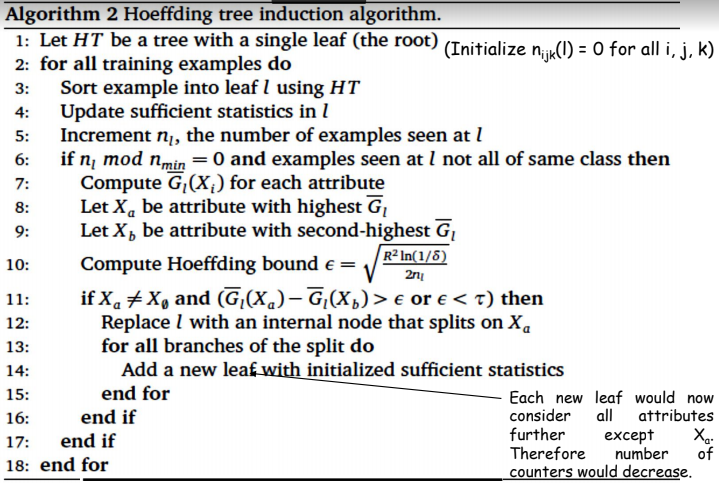

In [0]:
from sklearn.tree import DecisionTreeClassifier
def test_run():
    #calling time library to start the calculation for time of execution
    start_time = time.time()
    #reading waveform data
    df = pd.read_csv('waveform.data', header=None, sep=',')
    print(df)
    
    df = df.sample(frac=1).reset_index(drop=True)  # shuffle data rows
    title = list(df.columns.values) #extracting column names
    features = title[:-1] #extracting features by excluding last column 
    rows = df.shape[0] #Extracting number of rows using shape
    
    print("Rows:",rows)
    print("Features:", features)
   
    # convert df to data examples
    n_training = 4500
    array = df.head(n_training).values
    #dividing training set into 5 chunks
    set1 = array[:900, :]
    set2 = array[900:1800, :]
    set3 = array[1800:2700, :]
    set4 = array[2700:3600, :]
    set5 = array[3600:, :]

    # to simulate continuous training, modify the tree for each training set
    examples = [set1, set2, set3, set4, set5]
    print("Examples:",len(examples))
    # allocating test set
    n_test = 500
    test_set = df.tail(n_test).values
    x_test = test_set[:, :-1]
    y_test = test_set[:, -1]
    #initialising tree with features 
    tree = Vfdt(features, delta=0.01, nmin=100, tau=0.5)
    
    print('Training size: ', n_training)
    print('Test set size: ', n_test)
    
    n = 0
    for training_set in examples:
        n += len(training_set)
        x_train = training_set[:, :-1] #assigning training data
        y_train = training_set[:, -1] #assigning target
        tree.update(x_train, y_train) #updating tree 
        y_pred =tree.predict(x_test) #making predictions on test data

        print('Training set:', n)
        print('Accuracy',accuracy_score(y_test, y_pred)) #finding accuracy

    #printing running time
    print("Running time: %.6f seconds ---" % (time.time() - start_time))

In [0]:
if __name__ == "__main__":
    test_run() #calling test_run function

        0     1     2     3     4     5   ...    16    17    18    19    20  21
0    -1.23 -1.56 -1.75 -0.28  0.60  2.22  ...  5.12  3.32  1.20  0.24 -0.56   2
1    -0.69  2.43  0.61  2.08  2.30  3.25  ...  0.83  1.41  1.78  0.60  2.42   1
2    -0.12 -0.94  1.29  2.59  2.42  3.55  ...  0.64  0.62 -0.01 -0.79 -0.12   0
3     0.86  0.29  2.19 -0.02  1.13  2.51  ...  1.07 -1.43  2.84 -1.18  1.12   1
4     1.16  0.37  0.40 -0.59  2.66  1.00  ... -0.18  0.13 -0.21 -0.80 -0.68   1
...    ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...  ..
4995 -0.65  0.69  2.29 -0.16  0.51  0.26  ...  3.10  3.86  2.96  1.09 -1.42   0
4996 -0.02  0.67  2.34  3.18  2.16  4.77  ... -1.18 -0.56  0.02 -1.05 -0.18   1
4997  0.01 -1.99  0.16  2.30 -0.53  1.93  ... -0.52  0.62  1.00  1.21 -0.27   1
4998 -0.40  0.41 -0.48  1.04  0.79 -0.66  ...  3.83  1.72  2.08  1.31  1.37   0
4999  0.63 -0.07  2.71  2.55  3.36  3.22  ...  1.27 -0.53  0.09  0.01  0.60   1

[5000 rows x 22 columns]
Rows: 5000
Fea